## İmport İşlemleri

In [40]:
%pip install nltk
%pip install tweepy
%pip install pandas
%pip install wordcloud
%pip install textblob
%pip install seaborn
%pip install sklearn
%pip install zemberek
%pip install trnltk
%pip install git+https://github.com/emres/turkish-deasciifier.git
%pip install transformers datasets
%pip install torch
%pip install tensorflow --upgrade
%pip install pyautogui
%pip install snowballstemmer
%pip install vaderSentiment
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
%pip install -Uqr models/official/requirements.txt
%pip install --upgrade tensorflow-hub
%pip install tensorflow-gpu keras


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement zemberek (from versions: none)
ERROR: No matching distribution found for zemberek


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/emres/turkish-deasciifier.git to c:\users\cemke\appdata\local\temp\pip-req-build-q55d97uk
  Resolved https://github.com/emres/turkish-deasciifier.git to commit 665154c734b09485c3d11ce0038cd121dd109594
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/emres/turkish-deasciifier.git 'C:\Users\cemke\AppData\Local\Temp\pip-req-build-q55d97uk'


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.10.1 requires keras<2.11,>=2.10.0, but you have keras 2.11.0 which is incompatible.
tensorflow-gpu 2.10.1 requires tensorboard<2.11,>=2.10, but you have tensorboard 2.11.2 which is incompatible.
tensorflow-gpu 2.10.1 requires tensorflow-estimator<2.11,>=2.10.0, but you have tensorflow-estimator 2.11.0 which is incompatible.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'models/official/requirements.txt'


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successfully uninstalled tensorboard-2.11.2
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorboard<2.12,>=2.11, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-intel 2.11.0 requires tensorflow-estimator<2.12,>=2.11.0, but you have tensorflow-estimator 2.10.0 which is incompatible.


In [41]:
#!/usr/bin/env python
#-*-coding:utf-8-*-
from zemberek import (
    TurkishSpellChecker,
    TurkishSentenceNormalizer,
    TurkishSentenceExtractor,
    TurkishMorphology,
    TurkishTokenizer
)
import pyautogui
import tweepy
import csv
import sys
import os
import json
import tensorflow_hub as hub
import time
import re
import torch
from tqdm import tqdm
import warnings
import string
import pandas as pd
import numpy as np
import ast
import nltk
from snowballstemmer import TurkishStemmer as snowTurkish
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import datasets, svm, metrics
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as st
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from tweepy import Stream ,OAuthHandler
from tweepy.streaming import Stream
from wordcloud import WordCloud
from textblob import TextBlob
import tensorflow as tf
from keras.preprocessing.text import Tokenizer as tk
from keras.utils.data_utils import pad_sequences
from trnlp import TrnlpWord
from trnlp import *
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer, 
    TextClassificationPipeline, 
    pipeline, 
    AutoModelWithLMHead,
    AutoModel,
    ElectraTokenizer, 
    TFElectraForMultipleChoice,
    TFElectraForSequenceClassification,
    BertTokenizer
    )
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from torch.utils.data import TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
# Sınıflandırma Modellerine Ait Kütüphaneler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
%matplotlib inline
warnings.filterwarnings('ignore')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\cemke\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cemke\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cemke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Twitter Veri Çekme ve Temizleme Sınıfı

In [42]:
class getTweets:
    
    def __init__(self,ckey,csecret,atoken,asecret):#class yapıcı fonksiyon, tokenleri tanımlıyoruz
        self.api=None
        self.consumer_key = ckey
        self.consumer_secret = csecret
        self.access_token = atoken
        self.access_token_secret = asecret
        
    def setAuth(self):#tokenler ile twitter api bağlantısı yapıyoruz
        try:
            self.auth = tweepy.OAuthHandler(self.consumer_key, self.consumer_secret)
            self.auth.set_access_token(self.access_token, self.access_token_secret)
            self.api = tweepy.API(self.auth)            
            print ("Bağlantı Yapıldı!")                           
        except tweepy.TweepError as err:
            print('Error: {}'.format(err))   
    
    def toDataFrame(tweets):#Ver seti oluşturma fonksiyonu
        try:
            print ("Veriler Kayıt Ediliyor...")
            pd.set_option('display.max_rows', None)
            pd.set_option('display.max_columns', None)
            pd.set_option('display.width', None)
            pd.set_option('display.max_colwidth', None)
            DataSet = pd.DataFrame()#Boş dataset oluşturduk            
            DataSet['Kullanıcı_Adı'] = [tweet.user.name for tweet in tweets]#Kullanıcı adını ekledik
            DataSet['Tweet_Tarih'] = [tweet.created_at for tweet in tweets]#Tweet tarihini ekledik   
            DataSet['Tweet'] = [tweet.full_text for tweet in tweets]#Tweeti ekledik
            #Datasette kalabalık yapmaması için alttaki verileri almadım
            #DataSet['Tweet_Id'] = [tweet.id for tweet in tweets]           
            #DataSet['Tweet_Degistirilmis'] = [tweet.full_text for tweet in tweets]
            #DataSet['Tweet_Ceviri']=[tweet.full_text for tweet in tweets]            
            #DataSet['Kullanıcı_Id'] = [tweet.user.id for tweet in tweets]                
            #DataSet['Dil'] = [tweet.lang for tweet in tweets]
            DataSet.to_csv('Datasets/tw.csv',index=False)#Dataseti kayıt ettik
            print ("Veriler Kayıt Edildi!")
            return DataSet
        except Exception as err:
            print('Error: {}'.format(err))
    
    def searchTweet(self,arananTweet):#tweet aramak için kullanılan fonksiyon
        self.setAuth()
        try:                      
            print ("Kelimeye Uygun Tweetler Sorgulanıyor...")
            cursor = tweepy.Cursor(self.api.search_tweets, q=arananTweet,result_type="new", lang='tr',tweet_mode="extended") #Arama parametreleri ve arama fonksiyonu
            #Cursor ile yapmamızın nedeni Tweet limitinden kurtulmak
            results=[]
            for item in cursor.items(150):#kaç adet tweet alacağımız ve alınan tweetleri listeye atama işlemi
                results.append(item)
            print ("Kelimeye Uygun Tweetler Sorgulandı!")
            DataSet = getTweets.toDataFrame(results)#Alınan verileri Veri seti haline getirecek fonksiyona gönderiyoruz            
        except Exception as err:
            print('Error: {}'.format(err))
        finally:
            Dataset=pd.read_csv('Datasets/tw.csv',encoding="utf-8")                   
            getTweets.TweetClear(Dataset)#Tweet Temizlemek için
            getTweets.SentenceNormalization(Dataset)#Türkçe hatalı yazılmış kelimeleri düzeltmek için
            getTweets.TweetTranslate(Dataset)#Tweetleri İngilizceye çevirmek için
            getTweets.EngWordSeparation(Dataset)#İngilizce kelime Stopwords 
            getTweets.TrWordSeparation(Dataset)#Türkçe kelime Stopwords
            getTweets.ToxicSentence(Dataset)#İngilizce Argo cümle bulmak için             
            getTweets.TrStemmed(Dataset)#Türkçe Kelime köklerini almak için
            getTweets.EngStemmed(Dataset)#İngilizce Kelime köklerini almak için
            getTweets.TextblobSentiment(Dataset)#Textblob Duygu Analizi (Kelime pozitif negatif olarak sorguluyor)           
            Dataset.to_csv('Datasets/tw.csv',index=False)

    def TextblobSentiment(DataSet):#ingilizce cümle duygu analizi fonksiyonu 
        try:
            data=DataSet
            print ("Duygu Analizi Yapılıyor...")            
            data["TextBlobTür"] = data["Tweet_Ayrı_Eng"].apply(getTweets.getPolarity)
            data["TextBlobYoğunluk"] = data["Tweet_Ayrı_Eng"].apply(getTweets.getSubjectivity)
            data.to_csv('Datasets/textblob_eng_duygu.csv',index=False)
            print("Duygu Analizi Yapıldı!")                        
        except Exception as err:
            print('Error: {}'.format(err)) 
            
    def TweetClear(DataSet):#tweetleri duygu belli etmeyen ifadelerden temizlediğimiz fonksiyon
        try:
            data=DataSet
            print ("Tweetler Temizleniyor...")
            data["Tweet_Clear"]=data["Tweet"]
            pattern = re.compile('http[s]?://(?:[a-zA-Z0-9ğüşöçıİĞÜŞÖÇ]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+|#[a-zA-Z0-9ğüşöçıİĞÜŞÖÇ]+|$[a-zA-ZğüşöçıİĞÜŞÖÇ]+|@[a-zA-Z0-9ğüşöçıİĞÜŞÖÇ_]+|[,.^_$*%-;鶯!?’"“”:=|…#]+|\n+|amp[\s]+|gt;')
            for index in range(len(data["Tweet_Clear"])):        
                data["Tweet_Clear"][index]=pattern.sub(' ', data["Tweet_Clear"][index])    
                data["Tweet_Clear"][index]=data["Tweet_Clear"][index].lower()              
            data["Tweet_Clear"]=data["Tweet_Clear"].str.replace("[^\w\s]","")
            print ("Tweetler Temizlendi!")
            return data
        except Exception as err:
            print('Error: {}'.format(err))  
                              
    def TweetTranslate(DataSet):#türkçe tweetleri inglizce diline çevirdiğimiz fonksiyon        
        try:
            data=DataSet
            print ("Tweetler Çeviriliyor...")
            data["Tweet_Eng"]=data["Tweet_Clear"]
            for index in range(len(data["Tweet_Eng"])):
                Ceviri_Blob=TextBlob(data["Tweet_Eng"][index])
                Eng_Blob=Ceviri_Blob.translate(from_lang='tr', to='en')  
                data["Tweet_Eng"][index]=Eng_Blob  
                data["Tweet_Eng"][index]=data["Tweet_Eng"][index].lower()
            print ("Tweetler Çevirildi!")                      
            return data      
        except Exception as err:
            print('Error: {}'.format(err)) 
            
    def SentenceNormalization(DataSet):#türkçe temizlenmiş tweetlerde hatalı kelimeleri düzelttiğimiz fonksiyon
        try:
            data=DataSet
            print("Cümle Normalizasyonu Yapılıyor...")
            morphology = TurkishMorphology.create_with_defaults()
            normalizer = TurkishSentenceNormalizer(morphology)
            for index in range(len(data["Tweet_Clear"])):                
                data["Tweet_Clear"][index]= normalizer.normalize(data["Tweet_Clear"][index].lower())
            print("Cümle Normalizasyonu Yapıldı!")
            return data
        except Exception as err:
            print('Error: {}'.format(err))
            
    def TrWordSeparation(DataSet):#türkçe tweetleri durak kelimelerinden ayırdığımız fonksiyon
        try:
            data=DataSet
            print("Türkçe Kelime Ayrıştırma Yapılıyor...")
            data["Tweet_Ayrı_TR"]=data["Tweet_Clear"]
            for index in range(len(data["Tweet_Ayrı_TR"])):
                data["Tweet_Ayrı_TR"][index] = simple_token(data["Tweet_Ayrı_TR"][index], sw=stopwords)
            data["Tweet_Ayrı_TR"] = data["Tweet_Ayrı_TR"].str.join(" ")
            print("Türkçe Kelime Ayrıştırma Yapıldı!")
            return data
        except Exception as err:
            print('Error: {}'.format(err))  
                  
    def EngWordSeparation(DataSet):#ingilizce tweetleri durak kelimelerinden ayırdığımız fonksiyon
        try:
            data=DataSet
            print("İngilizce Kelime Ayrıştırma Yapılıyor...")
            additional  = ['sq','gt','mk','aq','qq','amk']#türkçe anlamı bilinmeyen kısaltmalar çeviri yapılırken cümleden atılmadığı için o kelimeleri ekstra biz sorguluyoruz
            stop = st.words('english')
            
            data["Tweet_Ayrı_Eng"] = data["Tweet_Eng"].str.split()           
            data["Tweet_Ayrı_Eng"] = data["Tweet_Ayrı_Eng"].apply(lambda x: [item for item in x if item not in stop])
            data["Tweet_Ayrı_Eng"] = data["Tweet_Ayrı_Eng"].apply(lambda x: [item for item in x if item not in additional])
            data["Tweet_Ayrı_Eng"] = data["Tweet_Ayrı_Eng"].str.join(" ")
            print("İngilizce Kelime Ayrıştırma Yapıldı!")
            return data
        except Exception as err:
            print('Error: {}'.format(err))
            
    def TrStemmed(DataSet):#türkçe tweetleri köklerine indirgediğimiz fonksiyon
        try:
            data=DataSet
            data["TR_Kök"] = data["Tweet_Ayrı_TR"]
            # Kök Bulma
            stemmer = snowTurkish()

            stemmed_lists = []
            for index in tqdm(data["TR_Kök"].index):
                mini_l = []
                for text in data.loc[index]["TR_Kök"].split(" "):
                    mini_l.append(stemmer.stemWord(text))

                big_text=" "
                for char in mini_l:
                    big_text = big_text + " " + char
                stemmed_lists.append(big_text)
    
            DataSet['TR_Kök'] = stemmed_lists
            return data
        except Exception as err:
            print('Error: {}'.format(err))
            
    def EngStemmed(DataSet):#ingilizce tweetleri köklerine indirgediğimiz fonksiyon
        try:
            data=DataSet
            data["Eng_Kök"] = data["Tweet_Ayrı_Eng"]
            # Kök Bulma
            stemmer = PorterStemmer()

            stemmed_lists = []
            for index in tqdm(data["Eng_Kök"].index):
                mini_l = []
                for text in data.loc[index]["Eng_Kök"].split(" "):
                    mini_l.append(stemmer.stem(text))

                big_text=" "
                for char in mini_l:
                    big_text = big_text + " " + char
                stemmed_lists.append(big_text)
    
            DataSet['Eng_Kök'] = stemmed_lists
            return data
        except Exception as err:
            print('Error: {}'.format(err))
            
    def ToxicSentence(DataSet):#türkçe cümlelerde argo, toksik kelime içeren tweetleri sorguladığımız fonksiyon
        try:
            data=DataSet
            print("Toxic Cümle Analizi Yapılıyor...")
            model_path ="martin-ha/toxic-comment-model"
            tokenizer=AutoTokenizer.from_pretrained(model_path)
            model=AutoModelForSequenceClassification.from_pretrained(model_path)
            pipeline=TextClassificationPipeline(model=model, tokenizer=tokenizer)
            data["Tweet_Toxic"]=data["Tweet_Eng"]
            temp=data["Tweet_Clear"]
            for index in range(len(data["Tweet_Toxic"])):
                sonuc=pipeline(str(data["Tweet_Toxic"][index]))
                if sonuc[0]['label']=="toxic":
                    data["Tweet_Toxic"][index]="Toxic"
                else:
                    data["Tweet_Toxic"][index]="Toxic değil"    
            print("Toxic Cümle Analizi Yapıldı!")
            return data  
        except Exception as err:
            print('Error: {}'.format(err))
        
    def getSubjectivity(DataSet):#textblob cümle duygu türü sorgusu için fonksiyon
        try: 
            sub=TextBlob(DataSet).sentiment.subjectivity               
            if sub >=0.75:
                return "%75 - %100"
            elif sub >=0.5 and sub <0.75:
                return "%50 - %75"
            elif sub >=0.25 and sub <0.50:
                return "%25 - %50"
            else:
                return "0 - 25%"
        except Exception as err:
            print('Error: {}'.format(err))
            
    def getPolarity(DataSet):#textblob cümle duygu yoğunluğu sorgusu için fonksiyon
        try:
            pol=TextBlob(DataSet).sentiment.polarity
            if pol>0.1:
                return "Pozitif"
            elif pol<-0.1:
                return "Negatif"
            else:
                return "Nötr"
        except Exception as err:
            print('Error: {}'.format(err))

## Class'a Kullanıcı Tarafından Veri Gönderdirilen Bölüm

In [43]:
tw = getTweets( 
ckey = 'o7qidRODRWm5u07PtAWrCpSqf',
csecret = '1Yn60OYMJl5kRCSM0XQ4Lskxh6hjM4VMz51OdsS6dM9DQuQ4MV',
atoken = '1315792402234441730-Dt7AydgVGYI5VN9RRQfnR8Endh0WAc',
asecret = 'jhfiDfB53Z27EqHfvfKbNdo0w2SWLqyyoAkILqgSoaGMK'
)
while True:
    #pyautogui kütüphanesi ile arayüz ekledik
    aramaTuru=pyautogui.confirm('Ne Tür Bir Arama Yapacaksınız?',title='Arama Türü', buttons=['Hastag','Kelime','Kullanıcı'])
    if aramaTuru=="Hastag":
        arananKelime=pyautogui.prompt(text="Aranacak Kelimeyi Girin:", title='Aranacak Kelime' , default='python')
        temp=("#"+arananKelime+" -filter:retweets")
        tw.searchTweet(arananTweet=temp)
        secim=pyautogui.confirm(text='Tekrar Denemek İster Misiniz?', title='Hata', buttons=["Tekrar","İptal"])
        if secim=="Tekrar":
            continue
        else:
            break
    elif aramaTuru=='Kelime':
        arananKelime=pyautogui.prompt(text="Aranacak Kelimeyi Girin:", title='Aranacak Kelime' , default='python')
        temp=(arananKelime+" -filter:retweets")
        tw.searchTweet(arananTweet=temp)
        secim=pyautogui.confirm(text='Tekrar Denemek İster Misiniz?', title='Hata', buttons=["Tekrar","İptal"])
        if secim=="Tekrar":
            continue
        else:
            break
    elif aramaTuru=='Kullanıcı':
        arananKelime=pyautogui.prompt(text="Aranacak Kelimeyi Girin:", title='Aranacak Kelime' , default='python')
        temp=("@"+arananKelime+" -filter:retweets")
        tw.searchTweet(temp)
        secim=pyautogui.confirm(text='Tekrar Denemek İster Misiniz?', title='Hata', buttons=["Tekrar","İptal"])
        if secim=="Tekrar":
            continue
        else:
            break
    else:
        secim=pyautogui.confirm(text='Hatalı Seçim Yaptınız Tekrar Denemek İster Misiniz?', title='Hata', buttons=["Tekrar","Kapat"])
        if secim=="Tekrar":
            continue
        else:
            break

Bağlantı Yapıldı!
Kelimeye Uygun Tweetler Sorgulanıyor...
Kelimeye Uygun Tweetler Sorgulandı!
Veriler Kayıt Ediliyor...
Veriler Kayıt Edildi!
Tweetler Temizleniyor...
Tweetler Temizlendi!
Cümle Normalizasyonu Yapılıyor...
2023-01-24 07:05:33,782 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 7.117197036743164

Cümle Normalizasyonu Yapıldı!
Tweetler Çeviriliyor...
Error: Translation API returned the input string unchanged.
İngilizce Kelime Ayrıştırma Yapılıyor...
İngilizce Kelime Ayrıştırma Yapıldı!
Türkçe Kelime Ayrıştırma Yapılıyor...
Türkçe Kelime Ayrıştırma Yapıldı!
Toxic Cümle Analizi Yapılıyor...
Toxic Cümle Analizi Yapıldı!


100%|██████████| 150/150 [00:00<00:00, 3858.94it/s]


Duygu Analizi Yapılıyor...
Duygu Analizi Yapıldı!


## OLUŞTURDUĞUMUZ TWİTTER VERİSETİ

In [44]:
Data=pd.read_csv('Datasets/textblob_eng_duygu.csv')
Data.head(10)

,Kullanıcı_Adı,Tweet_Tarih,Tweet,Tweet_Clear,Tweet_Eng,Tweet_Ayrı_Eng,Tweet_Ayrı_TR,Tweet_Toxic,TR_Kök,Eng_Kök,TextBlobTür,TextBlobYoğunluk
0,Orhon Can Dağtekin,2023-01-24 04:02:14+00:00,"bunu da önermişler, python kodları da var analizleri anlatırken. book seçip 0 doları seçerek indirebilirsiniz. maili sallasanız da olur. https://t.co/2x2XHLC3Am",bunu da önermişler python kodları da var analizleri anlatırken book seçip doları seçerek indirebilirsiniz maili sallasanız da olur,they also suggested that python codes also have the analysis when explaining the book you can select the dollar you can download the mail,also suggested python codes also analysis explaining book select dollar download mail,önermişler python kodları analizleri anlatırken book seçip doları seçerek indirebilirsiniz maili sallasanız olur,Toxic değil,öner python kodu analiz anlatır book seçip do seçerek indirebilir mail sallasa olur,also suggest python code also analysi explain book select dollar download mail,Nötr,0 - 25%
1,Şırdancı Ahmet Usta,2023-01-24 02:45:27+00:00,Abla python kullansana mal mısın https://t.co/wH3pW2M0BU,abla python kullan mal mısın,"sister, use python, are you goods","sister, use python, goods",abla python kullan mal mısın,Toxic değil,ap python kulla mal mı,"sister, use python, good",Nötr,0 - 25%
2,Coding TXT,2023-01-24 00:46:53+00:00,"Python'da Veritabanı İşemleri Tablo Oluşturma,Veri Ekleme,Veri Güncelleme https://t.co/4STteCMzFt \n#python #db #sqlite3",python da veritabanı işlemleri tablo oluşturma veri ekleme veri güncelleme,database transactions in python creation creation data add data update,database transactions python creation creation data add data update,python veritabanı işlemleri tablo oluşturma veri ekleme veri güncelleme,Toxic değil,python veritaba işlem tablo oluşturma ver ekle ver güncelle,databas transact python creation creation data add data updat,Nötr,0 - 25%
3,Tolga Seyhan,2023-01-23 22:04:11+00:00,"@Benediximus_ @atilla_yayla @emrahgulsunar “C, Java, Python hep saymaya 0’dan başlıyor, dijital çağı yakalama noktasında…” falan dese daha mantıklı/inandırıcı olurdu.",c java python hep saymaya dan başlıyor dijital çağı yakalama noktasında falan dese daha mantıklı inandırıcı olurdu,"c java python always starts from counting, it would be more convincing if he said at the point of capturing the digital age or something.","c java python always starts counting, would convincing said point capturing digital age something.",c java python saymaya dan başlıyor dijital çağı yakalama noktasında dese mantıklı inandırıcı olurdu,Toxic değil,c jav python sayma dan başlıyor dijital çak yakala nokta des mantıklı inandırıç olur,"c java python alway start counting, would convinc said point captur digit age something.",Pozitif,%50 - %75
4,Bilginiz Olsun,2023-01-23 21:10:57+00:00,E-Devlet'te bulunan bazı eğitimler:\n\n- Yabancı dil eğitimleri\n\n- Arama motoru optimizasyonu ( SEO )\n\n- 3ds Max ile modelleme\n\n- Python ile programlama\n\n- SQL \n\n- Excel eğitimi https://t.co/eMg5IbHBrB,e devlet te bulunan bazı eğitimler yabancı dil eğitimleri arama motoru optimizasyonu seo ds max ile modelleme python ile programlama sql excel eğitimi,some trainings found in the state foreign language trainings search engine optimization seo ds max modeling with python with python sql excel training,trainings found state foreign language trainings search engine optimization seo ds max modeling python python sql excel training,e devlet te bulunan eğitimler yabancı dil eğitimleri arama motoru optimizasyonu seo ds max modelleme python programlama sql excel eğitimi,Toxic değil,e devlet te buluna eğitim yabancı dil eğitim ara motor optimizasyo seo ds max modelle python programla sql excel eğit,train found state foreign languag train search engin optim seo ds max model python python sql excel train,Negatif,0 - 25%
5,Zêlal Semizotu Koç,2023-01-23 19:35:15+00:00,Python'dan sonra R öğrenmek üzere çıktığım bu yolda şu an matris çalışıyorum. Az sonra ayt mat videola

## BERT MODEL

### bert-base-turkish-sentiment-cased

In [45]:
BertData=pd.read_csv('Datasets/textblob_eng_duygu.csv',
                     usecols=['Tweet','TextBlobTür','TextBlobYoğunluk','Tweet_Clear','Tweet_Eng'])
# Eğitilmiş Ağırlıkların Yüklenmesi

model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

sentiment_analysis_pipeline= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)
sentiment_result=[]
for text in tqdm(BertData["Tweet_Clear"]):
    result = sentiment_analysis_pipeline(text)[0]
    sentiment_result.append(result)
        
sentiment_result = pd.DataFrame(sentiment_result)
tweets = pd.concat([BertData,sentiment_result],axis=1)

tweets.to_csv("Datasets/Bert_Tr_Sonuc.csv",index=False)

BertData=pd.read_csv("Datasets/Bert_Tr_Sonuc.csv")
BertData.rename(columns={'label':'BertTür','score':'BertYoğunluk'}, inplace=True)
BertData["BertTür"]=BertData["BertTür"].map({'positive':'Pozitif','negative':'Negatif'})
BertData.head()

100%|██████████| 150/150 [00:07<00:00, 20.16it/s]


,Tweet,Tweet_Clear,Tweet_Eng,TextBlobTür,TextBlobYoğunluk,BertTür,BertYoğunluk
0,"bunu da önermişler, python kodları da var analizleri anlatırken. book seçip 0 doları seçerek indirebilirsiniz. maili sallasanız da olur. https://t.co/2x2XHLC3Am",bunu da önermişler python kodları da var analizleri anlatırken book seçip doları seçerek indirebilirsiniz maili sallasanız da olur,they also suggested that python codes also have the analysis when explaining the book you can select the dollar you can download the mail,Nötr,0 - 25%,Pozitif,0.608918
1,Abla python kullansana mal mısın https://t.co/wH3pW2M0BU,abla python kullan mal mısın,"sister, use python, are you goods",Nötr,0 - 25%,Negatif,0.880207
2,"Python'da Veritabanı İşemleri Tablo Oluşturma,Veri Ekleme,Veri Güncelleme https://t.co/4STteCMzFt \n#python #db #sqlite3",python da veritabanı işlemleri tablo oluşturma veri ekleme veri güncelleme,database transactions in python creation creation data add data update,Nötr,0 - 25%,Negatif,0.714410
3,"@Benediximus_ @atilla_yayla @emrahgulsunar “C, Java, Python hep saymaya 0’dan başlıyor, dijital çağı yakalama noktasında…” falan dese daha mantıklı/inandırıcı olurdu.",c java python hep saymaya dan başlıyor dijital çağı yakalama noktasında falan dese daha mantıklı inandırıcı olurdu,"c java python always starts from counting, it would be more convincing if he said at the point of capturing the digital age or something.",Pozitif,%50 - %75,Negatif,0.733756
4,E-Devlet'te bulunan bazı eğitimler:\n\n- Yabancı dil eğitimleri\n\n- Arama motoru optimizasyonu ( SEO )\n\n- 3ds Max ile modelleme\n\n- Python ile programlama\n\n- SQL \n\n- Excel eğitimi https://t.co/eMg5IbHBrB,e devlet te bulunan bazı eğitimler yabancı dil eğitimleri arama motoru optimizasyonu seo ds max ile modelleme python ile programlama sql excel eğitimi,some trainings found in the state foreign language trainings search engine optimization seo ds max modeling with python with python sql excel training,Negatif,0 - 25%,Pozitif,0.967860


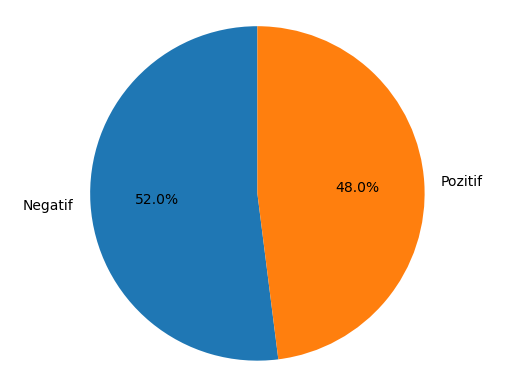

In [46]:
labels = BertData["BertTür"].map({"Pozitif":'Pozitif',"Negatif":'Negatif'}).value_counts().index.values
sizes = BertData["BertTür"].value_counts().values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90,explode=None)
ax1.axis('equal')
plt.show()

<AxesSubplot:xlabel='BertTür', ylabel='count'>

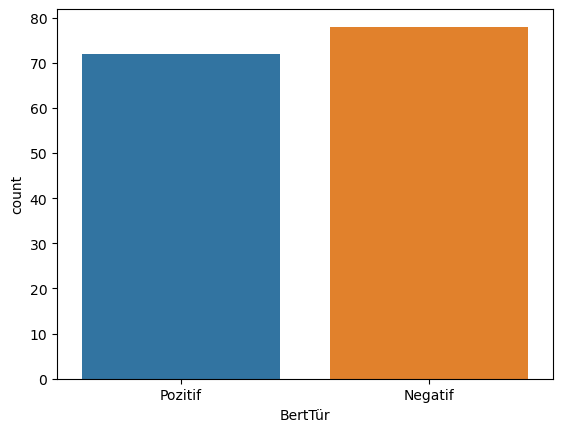

In [47]:
sns.countplot(BertData["BertTür"])

### bert-base-turkish-128k-uncased

In [48]:
Bert128Data=pd.read_csv('Datasets/textblob_eng_duygu.csv'
            ,usecols=['Tweet','TextBlobTür','TextBlobYoğunluk','Tweet_Clear','Tweet_Eng'])
# Eğitilmiş Ağırlıkların Yüklenmesi

model = AutoModelForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-128k-uncased")
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-uncased", do_lower_case=True)

sentiment_analysis_pipeline= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)
sentiment_result=[]
for text in tqdm(Bert128Data["Tweet_Clear"]):
    result = sentiment_analysis_pipeline(text)[0]
    sentiment_result.append(result)
        
sentiment_result = pd.DataFrame(sentiment_result)
tweets = pd.concat([Bert128Data,sentiment_result],axis=1)

tweets.to_csv("Datasets/Bert128_Tr_Sonuc.csv",index=False)
Bert128Data=pd.read_csv("Datasets/Bert128_Tr_Sonuc.csv")
Bert128Data.rename(columns={'label':'Bert128Tür','score':'Bert128Yoğunluk'}, inplace=True)
Bert128Data["Bert128Tür"]=Bert128Data["Bert128Tür"].map({'LABEL_0':'Pozitif','LABEL_1':'Negatif'})
Bert128Data.head()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

,Tweet,Tweet_Clear,Tweet_Eng,TextBlobTür,TextBlobYoğunluk,Bert128Tür,Bert128Yoğunluk
0,"bunu da önermişler, python kodları da var analizleri anlatırken. book seçip 0 doları seçerek indirebilirsiniz. maili sallasanız da olur. https://t.co/2x2XHLC3Am",bunu da önermişler python kodları da var analizleri anlatırken book seçip doları seçerek indirebilirsiniz maili sallasanız da olur,they also suggested that python codes also have the analysis when explaining the book you can select the dollar you can download the mail,Nötr,0 - 25%,Negatif,0.554421
1,Abla python kullansana mal mısın https://t.co/wH3pW2M0BU,abla python kullan mal mısın,"sister, use python, are you goods",Nötr,0 - 25%,Negatif,0.644364
2,"Python'da Veritabanı İşemleri Tablo Oluşturma,Veri Ekleme,Veri Güncelleme https://t.co/4STteCMzFt \n#python #db #sqlite3",python da veritabanı işlemleri tablo oluşturma veri ekleme veri güncelleme,database transactions in python creation creation data add data update,Nötr,0 - 25%,Negatif,0.523298
3,"@Benediximus_ @atilla_yayla @emrahgulsunar “C, Java, Python hep saymaya 0’dan başlıyor, dijital çağı yakalama noktasında…” falan dese daha mantıklı/inandırıcı olurdu.",c java python hep saymaya dan başlıyor dijital çağı yakalama noktasında falan dese daha mantıklı inandırıcı olurdu,"c java python always starts from counting, it would be more convincing if he said at the point of capturing the digital age or something.",Pozitif,%50 - %75,Pozitif,0.596653
4,E-Devlet'te bulunan bazı eğitimler:\n\n- Yabancı dil eğitimleri\n\n- Arama motoru optimizasyonu ( SEO )\n\n- 3ds Max ile modelleme\n\n- Python ile programlama\n\n- SQL \n\n- Excel eğitimi https://t.co/eMg5IbHBrB,e devlet te bulunan bazı eğitimler yabancı dil eğitimleri arama motoru optimizasyonu seo ds max ile modelleme python ile programlama sql excel eğitimi,some trainings found in the state foreign language trainings search engine optimization seo ds max modeling with python with python sql excel training,Negatif,0 - 25%,Pozitif,0.560004


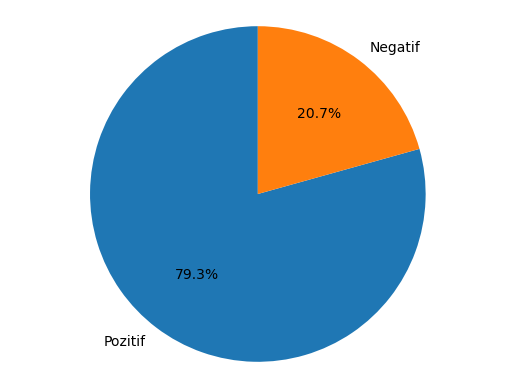

In [49]:
labels = Bert128Data["Bert128Tür"].map({"Pozitif":'Pozitif',"Negatif":'Negatif'}).value_counts().index.values
sizes = Bert128Data["Bert128Tür"].value_counts().values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90,explode=None)
ax1.axis('equal')
plt.show()

<AxesSubplot:xlabel='Bert128Tür', ylabel='count'>

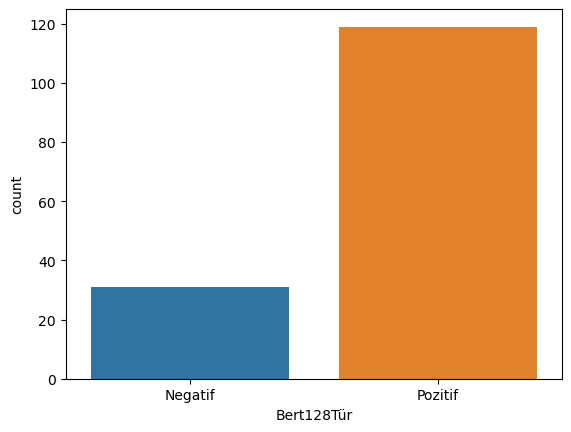

In [50]:
sns.countplot(Bert128Data["Bert128Tür"])

In [51]:
BertMiniData=pd.read_csv('Datasets/textblob_eng_duygu.csv',usecols=['Tweet','TextBlobTür','TextBlobYoğunluk','Tweet_Clear','Tweet_Eng'])

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/paraphrase-MiniLM-L6-v2')
sentiment_result=[]
# Tokenize sentences
for text in BertMiniData["Tweet_Eng"]:
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling. In this case, max pooling.
sentiment_result = mean_pooling(model_output, encoded_input['attention_mask'])
sentiment_result = pd.DataFrame(sentiment_result)

tweets = pd.concat([BertMiniData,sentiment_result],axis=1)
tweets.to_csv("Datasets/BertMini_Sonuc.csv",index=False)
BertMiniData=pd.read_csv("Datasets/BertMini_Sonuc.csv")
BertMiniData.head()

,Tweet,Tweet_Clear,Tweet_Eng,TextBlobTür,TextBlobYoğunluk,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383
0,"bunu da önermişler, python kodları da var analizleri anlatırken. book seçip 0 doları seçerek indirebilirsiniz. maili sallasanız da olur. https://t.co/2x2XHLC3Am",bunu da önermişler python kodları da var analizleri anlatırken book seçip doları seçerek indirebilirsiniz maili sallasanız da olur,they also suggested that python codes also have the analysis when explaining the book you can select the dollar you can download the mail,Nötr,0 - 25%,-0.032468,-0.267112,-0.388645,-0.107918,-0.372773,-0.054255,0.721727,-0.063463,-0.167473,0.124889,0.209764,0.083545,0.291318,0.019215,0.060809,0.092598,-0.132443,0.62436,-0.294374,-0.096216,-0.021653,-0.50962,-0.13587,-0.134713,0.321116,0.135831,0.070025,-0.329623,-0.142199,0.107061,-0.004413,0.50341,0.251366,-0.046078,0.199428,0.666655,-0.437042,-0.218911,-0.094696,0.208457,-0.340467,0.017363,0.055244,-0.18465,0.078167,-0.359911,-0.036826,0.003084,-0.13919,-0.056596,-0.638754,-0.220163,0.048508,-0.770096,0.187,-0.492412,0.335714,0.33065,-0.211803,-0.397115,-0.304522,0.146338,-0.172254,0.179986,-0.015519,0.178965,-0.310733,-0.055035,0.181066,-0.24616,0.0189,-0.068134,-0.527809,0.172374,-0.368099,0.016119,0.571836,0.480747,0.00876,-0.382467,0.076984,-0.010804,0.045139,0.021748,-0.218995,0.263389,0.348581,0.10177,0.438662,-0.423616,0.569668,0.386016,0.111748,-0.202787,0.310974,0.016201,0.498213,-0.428955,-0.098136,0.093892,0.034849,-0.151986,-0.010838,0.145713,-0.001814,-0.25322,0.4758,-0.348399,0.128427,0.025203,0.007301,-0.099846,-0.046715,0.019357,0.351432,-0.025464,0.151642,0.452691,0.014918,0.262903,-0.060872,0.092361,-0.056966,-0.117284,0.108609,0.190206,0.267056,0.12509,-0.374865,-0.050893,0.239136,-0.027447,-0.080255,0.156935,-0.022728,-0.02537,0.240122,-0.245096,-0.673325,-0.360006,-0.300717,-0.194371,0.264511,-0.144157,0.067831,0.289669,-0.05245,0.318879,-0.07747,0.324659,0.190954,-0.221715,0.002792,0.072996,0.222699,-0.237309,0.134246,0.092779,0.203033,-0.248051,-0.269641,0.386397,-0.433778,-0.017452,-0.322633,0.113894,-0.445172,0.012537,0.037189,0.118233,0.130137,0.007116,-0.020726,0.082719,-0.178069,0.081142,-0.365562,0.060745,0.152045,0.43247,-0.123896,0.252595,0.016814,-0.122705,0.025092,0.123053,0.0984,0.092322,0.055644,-0.554606,-0.000889,-0.482562,0.196542,-0.327999,0.123909,-0.276812,0.601117,0.160302,-0.201046,-0.033007,-0.301218,0.182625,0.284632,-0.289472,0.069735,-0.041135,0.20936,0.241158,-0.024038,0.418745,-0.058601,-0.178666,-0.107847,0.079679,-0.12518,-0.116635,0.376661,0.300586,-0.616645,-0.024142,-0.369902,

## ELECTRA (BERT MODEL TABANLI)

In [52]:
ElectraData=pd.read_csv('Datasets/textblob_eng_duygu.csv'
                ,usecols=['Tweet','TextBlobTür','TextBlobYoğunluk','Tweet_Clear','Tweet_Eng'])

tokenizer = ElectraTokenizer.from_pretrained("bhadresh-savani/electra-base-emotion")
model = TFElectraForSequenceClassification.from_pretrained("bhadresh-savani/electra-base-emotion")

sentiment_result=[]
for text in tqdm(ElectraData["Tweet_Eng"]):
    inputs = tokenizer(text, return_tensors="tf")
    logits = model(**inputs).logits
    predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
    result=model.config.id2label[predicted_class_id]
    sentiment_result.append(result)
        
sentiment_result = pd.DataFrame(sentiment_result)
tweets = pd.concat([ElectraData,sentiment_result],axis=1)
tweets.to_csv("Datasets/Electra_Eng_Sonuc.csv",index=False)

ElectraData=pd.read_csv("Datasets/Electra_Eng_Sonuc.csv")
ElectraData.rename(columns={"0":"ElectraTür"}, inplace=True)
ElectraData["ElectraTür"]=ElectraData["ElectraTür"].map(
    {"joy":'Mutlu',"anger":'Kızgın',"sadness":"Üzgün","fear":"Korku"})
ElectraData.head()


All model checkpoint layers were used when initializing TFElectraForSequenceClassification.

All the layers of TFElectraForSequenceClassification were initialized from the model checkpoint at bhadresh-savani/electra-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForSequenceClassification for predictions without further training.
100%|██████████| 150/150 [00:33<00:00,  4.52it/s]


,Tweet,Tweet_Clear,Tweet_Eng,TextBlobTür,TextBlobYoğunluk,ElectraTür
0,"bunu da önermişler, python kodları da var analizleri anlatırken. book seçip 0 doları seçerek indirebilirsiniz. maili sallasanız da olur. https://t.co/2x2XHLC3Am",bunu da önermişler python kodları da var analizleri anlatırken book seçip doları seçerek indirebilirsiniz maili sallasanız da olur,they also suggested that python codes also have the analysis when explaining the book you can select the dollar you can download the mail,Nötr,0 - 25%,Mutlu
1,Abla python kullansana mal mısın https://t.co/wH3pW2M0BU,abla python kullan mal mısın,"sister, use python, are you goods",Nötr,0 - 25%,Üzgün
2,"Python'da Veritabanı İşemleri Tablo Oluşturma,Veri Ekleme,Veri Güncelleme https://t.co/4STteCMzFt \n#python #db #sqlite3",python da veritabanı işlemleri tablo oluşturma veri ekleme veri güncelleme,database transactions in python creation creation data add data update,Nötr,0 - 25%,Kızgın
3,"@Benediximus_ @atilla_yayla @emrahgulsunar “C, Java, Python hep saymaya 0’dan başlıyor, dijital çağı yakalama noktasında…” falan dese daha mantıklı/inandırıcı olurdu.",c java python hep saymaya dan başlıyor dijital çağı yakalama noktasında falan dese daha mantıklı inandırıcı olurdu,"c java python always starts from counting, it would be more convincing if he said at the point of capturing the digital age or something.",Pozitif,%50 - %75,Mutlu
4,E-Devlet'te bulunan bazı eğitimler:\n\n- Yabancı dil eğitimleri\n\n- Arama motoru optimizasyonu ( SEO )\n\n- 3ds Max ile modelleme\n\n- Python ile programlama\n\n- SQL \n\n- Excel eğitimi https://t.co/eMg5IbHBrB,e devlet te bulunan bazı eğitimler yabancı dil eğitimleri arama motoru optimizasyonu seo ds max ile modelleme python ile programlama sql excel eğitimi,some trainings found in the state foreign language trainings search engine optimization seo ds max modeling with python with python sql excel training,Negatif,0 - 25%,Mutlu


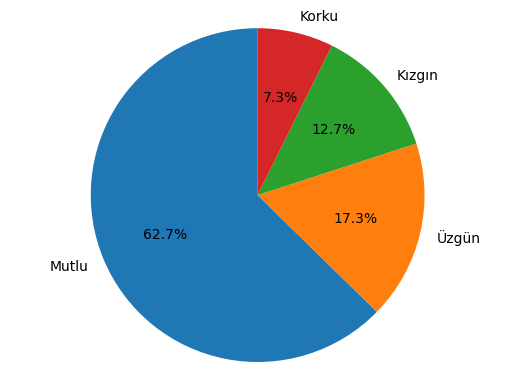

In [53]:
labels = ElectraData["ElectraTür"].map({"Mutlu":'Mutlu',"Kızgın":'Kızgın',"Üzgün":"Üzgün","Korku":"Korku"}).value_counts().index.values
sizes = ElectraData["ElectraTür"].value_counts().values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90,explode=None)
ax1.axis('equal')
plt.show()

<AxesSubplot:xlabel='ElectraTür', ylabel='count'>

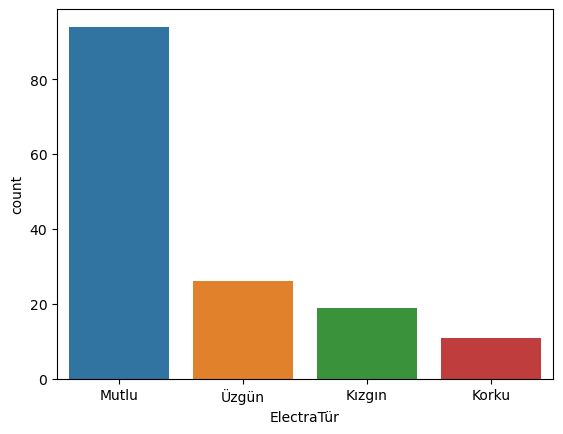

In [54]:
sns.countplot(ElectraData["ElectraTür"])

## Vader Sentiment

In [55]:
sid_obj= SentimentIntensityAnalyzer()
VaderData=pd.read_csv('Datasets/textblob_eng_duygu.csv',
    usecols=['Tweet','TextBlobTür','TextBlobYoğunluk','Tweet_Clear','Tweet_Eng','Tweet_Ayrı_Eng'])
sentiment_result=[]
for text in tqdm(VaderData["Tweet_Ayrı_Eng"]):
    result = sid_obj.polarity_scores(text)
    sentiment_result.append(result)
        
sentiment_result = pd.DataFrame(sentiment_result)
tweets = pd.concat([VaderData,sentiment_result],axis=1)
tweets.to_csv("Datasets/Vader_Tr_Sonuc.csv",index=False)
VaderData=pd.read_csv("Datasets/Vader_Tr_Sonuc.csv")
VaderData.rename(columns=
    {"neg":"VaderNegatif",'neu':'VaderNötr','pos':'VaderPozitif','compound':'VaderYoğunluk'}, inplace=True)
VaderData.head()

100%|██████████| 150/150 [00:00<00:00, 21500.43it/s]


,Tweet,Tweet_Clear,Tweet_Eng,Tweet_Ayrı_Eng,TextBlobTür,TextBlobYoğunluk,VaderNegatif,VaderNötr,VaderPozitif,VaderYoğunluk
0,"bunu da önermişler, python kodları da var analizleri anlatırken. book seçip 0 doları seçerek indirebilirsiniz. maili sallasanız da olur. https://t.co/2x2XHLC3Am",bunu da önermişler python kodları da var analizleri anlatırken book seçip doları seçerek indirebilirsiniz maili sallasanız da olur,they also suggested that python codes also have the analysis when explaining the book you can select the dollar you can download the mail,also suggested python codes also analysis explaining book select dollar download mail,Nötr,0 - 25%,0.0,1.000,0.000,0.0000
1,Abla python kullansana mal mısın https://t.co/wH3pW2M0BU,abla python kullan mal mısın,"sister, use python, are you goods","sister, use python, goods",Nötr,0 - 25%,0.0,1.000,0.000,0.0000
2,"Python'da Veritabanı İşemleri Tablo Oluşturma,Veri Ekleme,Veri Güncelleme https://t.co/4STteCMzFt \n#python #db #sqlite3",python da veritabanı işlemleri tablo oluşturma veri ekleme veri güncelleme,database transactions in python creation creation data add data update,database transactions python creation creation data add data update,Nötr,0 - 25%,0.0,0.625,0.375,0.4939
3,"@Benediximus_ @atilla_yayla @emrahgulsunar “C, Java, Python hep saymaya 0’dan başlıyor, dijital çağı yakalama noktasında…” falan dese daha mantıklı/inandırıcı olurdu.",c java python hep saymaya dan başlıyor dijital çağı yakalama noktasında falan dese daha mantıklı inandırıcı olurdu,"c java python always starts from counting, it would be more convincing if he said at the point of capturing the digital age or something.","c java python always starts counting, would convincing said point capturing digital age something.",Pozitif,%50 - %75,0.0,0.828,0.172,0.4019
4,E-Devlet'te bulunan bazı eğitimler:\n\n- Yabancı dil eğitimleri\n\n- Arama motoru optimizasyonu ( SEO )\n\n- 3ds Max ile modelleme\n\n- Python ile programlama\n\n- SQL \n\n- Excel eğitimi https://t.co/eMg5IbHBrB,e devlet te bulunan bazı eğitimler yabancı dil eğitimleri arama motoru optimizasyonu seo ds max ile modelleme python ile programlama sql excel eğitimi,some trainings found in the state foreign language trainings search engine optimization seo ds max modeling with python with python sql excel training,trainings found state foreign language trainings search engine optimization seo ds max modeling python python sql excel training,Negatif,0 - 25%,0.0,0.741,0.259,0.6808


## Model Karşılaştırılması

In [56]:
temp = pd.DataFrame()
tweets = pd.concat([ElectraData,VaderData,BertData,Bert128Data],axis=1)
tweets.to_csv("Datasets/Duygu_Sonuc.csv",index=False)
temp=pd.read_csv('Datasets/Duygu_Sonuc.csv',usecols=['Tweet','Tweet_Clear','Tweet_Eng','TextBlobTür','ElectraTür','VaderPozitif','VaderNegatif','VaderNötr','BertTür','Bert128Tür'])
temp.head(20)

,Tweet,Tweet_Clear,Tweet_Eng,TextBlobTür,ElectraTür,VaderNegatif,VaderNötr,VaderPozitif,BertTür,Bert128Tür
0,"bunu da önermişler, python kodları da var analizleri anlatırken. book seçip 0 doları seçerek indirebilirsiniz. maili sallasanız da olur. https://t.co/2x2XHLC3Am",bunu da önermişler python kodları da var analizleri anlatırken book seçip doları seçerek indirebilirsiniz maili sallasanız da olur,they also suggested that python codes also have the analysis when explaining the book you can select the dollar you can download the mail,Nötr,Mutlu,0.000,1.000,0.000,Pozitif,Negatif
1,Abla python kullansana mal mısın https://t.co/wH3pW2M0BU,abla python kullan mal mısın,"sister, use python, are you goods",Nötr,Üzgün,0.000,1.000,0.000,Negatif,Negatif
2,"Python'da Veritabanı İşemleri Tablo Oluşturma,Veri Ekleme,Veri Güncelleme https://t.co/4STteCMzFt \n#python #db #sqlite3",python da veritabanı işlemleri tablo oluşturma veri ekleme veri güncelleme,database transactions in python creation creation data add data update,Nötr,Kızgın,0.000,0.625,0.375,Negatif,Negatif
3,"@Benediximus_ @atilla_yayla @emrahgulsunar “C, Java, Python hep saymaya 0’dan başlıyor, dijital çağı yakalama noktasında…” falan dese daha mantıklı/inandırıcı olurdu.",c java python hep saymaya dan başlıyor dijital çağı yakalama noktasında falan dese daha mantıklı inandırıcı olurdu,"c java python always starts from counting, it would be more convincing if he said at the point of capturing the digital age or something.",Pozitif,Mutlu,0.000,0.828,0.172,Negatif,Pozitif
4,E-Devlet'te bulunan bazı eğitimler:\n\n- Yabancı dil eğitimleri\n\n- Arama motoru optimizasyonu ( SEO )\n\n- 3ds Max ile modelleme\n\n- Python ile programlama\n\n- SQL \n\n- Excel eğitimi https://t.co/eMg5IbHBrB,e devlet te bulunan bazı eğitimler yabancı dil eğitimleri arama motoru optimizasyonu seo ds max ile modelleme python ile programlama sql excel eğitimi,some trainings found in the state foreign language trainings search engine optimization seo ds max modeling with python with python sql excel training,Negatif,Mutlu,0.000,0.741,0.259,Pozitif,Pozitif
5,Python'dan sonra R öğrenmek üzere çıktığım bu yolda şu an matris çalışıyorum. Az sonra ayt mat videolarına bağlanıp soru bankası sipariş ediyorum glb,python dan sonra r öğrenmek üzere çıktığım bu yolda şu an matris çalışıyorum az sonra ayt mat videolarına bağlanıp soru bankası sipariş ediyorum galiba,"after python, i am currently working on this road to learn r.",Nötr,Mutlu,0.000,1.000,0.000,Pozitif,Pozitif
6,Python ile Derin Öğrenme - François Chollet kitabina ihtiyaci olan varsa gonderebilirim.,python ile derin öğrenme françois Cholet kitabına ihtiyacı olan varsa gönderebilirim,"deep learning with python, i can send françois cholet if anyone needs it",Nötr,Mutlu,0.000,1.000,0.000,Pozitif,Pozitif
7,@rdvnblmr1 Şuan 8. Sınıf olduğum için yazılım derslerine bir müddet ara vermek zorunda kaldım ama bu süre zarfında kendimi geliştirdim. Python'da bir sürü proje yaptım ve yapmaya devam ediyorum. LGS den hemen sonra kursa devam edeceğim.,şu an sınıf olduğum için yazılım derslerine bir müddet ara vermek zorunda kaldım ama bu süre zarfında kendimi geliştirdim python da bir sürü proje yaptım ve yapmaya devam ediyorum lgs den hemen sonra kursa devam edeceğim,"since i am a class now, i had to take a break in software lessons for a while, but during this time i developed myself in python, i did a lot of projects and i continue to do so i will continue the course immediately after lgs",Nötr,Mutlu,0.000,1.000,0.000,Pozitif,Pozitif
8,Matematik dersi için random modülü ile sayı tahmin oyunu\n#Python #random https://t.co/amx1SMSmDb,matematik dersi için random modülü ile sayı tahmin oyunu,number estimation game with random module for math lesson,Negatif,Korku,0.000,0.822,0.178,Negatif,Pozitif
9,"Yazılımla eğitim-öğretim, sınav vb gibi bir çok iş kolay hale geliyor:)#Python #javascript #c++ https://t.co/7RtUfrMRLe",yazılımla eğitim öğretim sınav vb gibi bir çok iş kolay hale

## Son Model

### Eğitim Dataset Temizliği

In [57]:

temp=pd.read_csv("Test/apple-twitter-sentiment-texts.csv").dropna()
def TweetClear(DataSet):
     try:
         data=DataSet
         print ("Tweetler Temizleniyor...")
         data["Text_Clear"]=data["text"]
         pattern = re.compile('http[s]?://(?:[a-zA-Z0-9ğüşöçıİĞÜŞÖÇ]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F]))+|#[a-zA-Z0-9ğüşöçıİĞÜŞÖÇ]+|$[a-zA-Z0-9ğüşöçıİĞÜŞÖÇ]+|@[a-zA-Z0-9ğüşöçıİĞÜŞÖÇ_]+|[,.^_$*%-;鶯!?’"“”:=|…#]+|\n+|amp[\s]+|gt;')
         for index in range(len(data["Text_Clear"])):        
             data["Text_Clear"][index]=pattern.sub(' ', data["Text_Clear"][index])    
             data["Text_Clear"][index]=data["Text_Clear"][index].lower()              
         data["Text_Clear"]=data["Text_Clear"].str.replace("[^\w\s]","")
         print ("Tweetler Temizlendi!")
         return data
     except Exception as err:
         print('Error: {}'.format(err))  

def WordSeparation(DataSet):
    try:
        data=DataSet
        print("İngilizce Kelime Ayrıştırma Yapılıyor...")
        additional  = ['sq','gt','mk','aq','qq','amk','rt']
        stop = st.words('english')
        
        data["Stopword"] = data["Text_Clear"].str.split()           
        data["Stopword"] = data["Stopword"].apply(lambda x: [item for item in x if item not in stop])
        data["Stopword"] = data["Stopword"].apply(lambda x: [item for item in x if item not in additional])
        data["Stopword"] = data["Stopword"].str.join(' ')
        print("İngilizce Kelime Ayrıştırma Yapıldı!")
        return data
    except Exception as err:
        print('Error: {}'.format(err))
        
def Translate(DataSet):
    try:
        data=DataSet
        print ("Tweetler Çeviriliyor...")
        data["Text_Tr"]=data["Text_Clear"]
        for index in range(len(data["Text_Tr"])):
            Ceviri_Blob=TextBlob(data["Text_Tr"][index])
            Eng_Blob=Ceviri_Blob.translate(from_lang='en', to='tr')  
            data["Text_Tr"][index]=Eng_Blob  
            data["Text_Tr"][index]=data["Text_Tr"][index].lower()
        print ("Tweetler Çevirildi!")  
        return data
    except Exception as err:
        print('Error: {}'.format(err))

def WordSeparationTr(DataSet):
    try:
        data=DataSet
        print("İngilizce Kelime Ayrıştırma Yapılıyor...")
        additional  = ['sq','gt','mk','aq','qq','amk','rt']
        stop = st.words('turkish')
        
        data["Stopword_Tr"] = data["Text_Tr"].str.split()           
        data["Stopword_Tr"] = data["Stopword_Tr"].apply(lambda x: [item for item in x if item not in stop])
        data["Stopword_Tr"] = data["Stopword_Tr"].apply(lambda x: [item for item in x if item not in additional])
        data["Stopword_Tr"] = data["Stopword_Tr"].str.join(' ')
        print("İngilizce Kelime Ayrıştırma Yapıldı!")
        return data
    except Exception as err:
        print('Error: {}'.format(err))
        
def Stemmed(DataSet):
    try:
        data=DataSet
        data["Stemmed"] = data["Stopword"]
        # Kök Bulma
        stemmer = PorterStemmer()
        stemmed_lists = []
        for index in tqdm(data["Stemmed"].index):
            mini_l = []
            for text in data.loc[index]["Stemmed"].split(" "):
                mini_l.append(stemmer.stem(text))
            big_text=" "
            for char in mini_l:
                big_text = big_text + " " + char
            stemmed_lists.append(big_text)

        DataSet['Stemmed'] = stemmed_lists
        return data
    except Exception as err:
        print('Error: {}'.format(err))
        
TweetClear(temp)
WordSeparation(temp)
Stemmed(temp)
#Translate(temp)
#WordSeparationTr(temp)
temp.to_csv("Test/testData.csv",index=False)
TestData=pd.read_csv("Test/testData.csv",encoding="Utf-8")
TestData.head(10)    

Tweetler Temizleniyor...
Tweetler Temizlendi!
İngilizce Kelime Ayrıştırma Yapılıyor...
İngilizce Kelime Ayrıştırma Yapıldı!


100%|██████████| 1630/1630 [00:00<00:00, 4754.22it/s]


,text,sentiment,Text_Clear,Stopword,Stemmed
0,Wow. Yall needa step it up @Apple RT @heynyla: Music and snapchat at the same damn time. Thank you #Note4,-1,wow yall needa step it up rt music and snapchat at the same damn time thank you,wow yall needa step music snapchat damn time thank,wow yall needa step music snapchat damn time thank
1,What Happened To Apple Inc? http://t.co/FJEXI3oP0U #aapl #apple @MoneyPress http://t.co/wXKmmTMArW,0,what happened to apple inc,happened apple inc,happen appl inc
2,Thank u @apple I can now compile all of the pics that i communicate with in one place http://t.co/tq1lo09oyA,1,thank u i can now compile all of the pics that i communicate with in one place,thank u compile pics communicate one place,thank u compil pic commun one place
3,The oddly uplifting story of the Apple co-founder who sold his stake for $800 \r\n$AAPL #aapl\r\nhttp://t.co/CiZbVR05PJ,0,the oddly uplifting story of the apple co founder who sold his stake for \r aapl \r,oddly uplifting story apple co founder sold stake aapl,oddli uplift stori appl co founder sold stake aapl
4,@apple can i exchange my iphone for a different color lmao i changed my mind,0,can i exchange my iphone for a different color lmao i changed my mind,exchange iphone different color lmao changed mind,exchang iphon differ color lmao chang mind
5,RT @JPDesloges: Apple Acted Unfairly In Suppressing Digital Music Competition: Paul Kedrosky $AAPL #aapl\r\nhttp://t.co/XTbFhpbYf7,-1,rt apple acted unfairly in suppressing digital music competition paul kedrosky aapl \r,apple acted unfairly suppressing digital music competition paul kedrosky aapl,appl act unfairli suppress digit music competit paul kedroski aapl
6,Let's not forget that press effects stock @Apple to Defend Against iPod Antitrust Suit http://t.co/pqJ0bKIMb8,0,let s not forget that press effects stock to defend against ipod antitrust suit,let forget press effects stock defend ipod antitrust suit,let forget press effect stock defend ipod antitrust suit
7,Apple Inc. Deleted Songs From Rival Services From iPods http://t.co/dQwDFpcc4x #AAPL,-1,apple inc deleted songs from rival services from ipods,apple inc deleted songs rival services ipods,appl inc delet song rival servic ipod
8,@TeamCavuto @Apple They're staging a die in ar an Apple store while being on their iPhone.,0,they re staging a die in ar an apple store while being on their iphone,staging die ar apple store iphone,stage die ar appl store iphon
9,"Happy Monday! My camera on my fancy @Apple #iPhone6Plus suddenly stopped working this weekend, so instead - I meme. http://t.co/XdySgcxUuv",-1,happy monday my camera on my fancy suddenly stopped working this weekend so instead i meme,happy monday camera fancy suddenly stopped working weekend instead meme,happi monday camera fanci suddenli stop work weekend instead meme


### Tenserflow.Keras Model

Model için ön yukarıda yapıldı işlemler yapıldı.

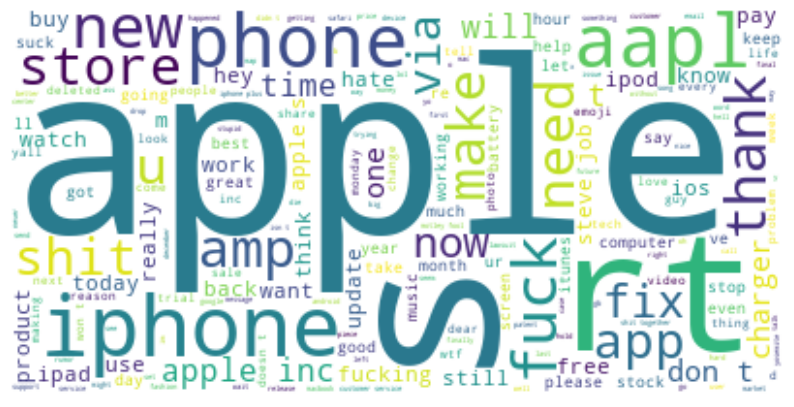

In [58]:
text = " ".join(review for review in TestData["Text_Clear"])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [59]:
max_words = 500
max_len= 40
def tokenize_pad_sequences(text):
    tokenizer = tk(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer
print('Before Tokenization & Padding \n',TestData["Text_Clear"][0])
X, tokenizer = tokenize_pad_sequences(TestData["Text_Clear"])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 wow  yall needa step it up   rt    music and snapchat at the same damn time  thank you  
After Tokenization & Padding 
 [450 153   8  41  17 103   9  32   1 299 349  75 144  12   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]


In [60]:
vocab_size = tokenizer.document_count

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 32),
    tf.keras.layers.LSTM(16, activation="relu"),
    tf.keras.layers.Dense(3, activation="relu")
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          52160     
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 55,347
Trainable params: 55,347
Non-trainable params: 0
_________________________________________________________________


In [61]:
y = pd.get_dummies(TestData["sentiment"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print('Train Set ->', X_train.shape, y_train.shape)
print('Test Set ->', X_test.shape, y_test.shape)



Train Set -> (1141, 40) (1141, 3)
Test Set -> (489, 40) (489, 3)


In [62]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
history = model.fit(X_train, y_train, epochs=4, batch_size=64,validation_data=(X_test, y_test))

Epoch 1/4
18/18 [==============================] - 2s 31ms/step - loss: 14.6348 - acc: 0.0920 - val_loss: 14.8656 - val_acc: 0.0777
Epoch 2/4
18/18 [==============================] - 0s 22ms/step - loss: 14.6348 - acc: 0.0920 - val_loss: 14.8656 - val_acc: 0.0777
Epoch 3/4
18/18 [==============================] - 0s 18ms/step - loss: 14.6348 - acc: 0.0920 - val_loss: 14.8656 - val_acc: 0.0777
Epoch 4/4
18/18 [==============================] - 0s 15ms/step - loss: 14.6348 - acc: 0.0920 - val_loss: 14.8656 - val_acc: 0.0777


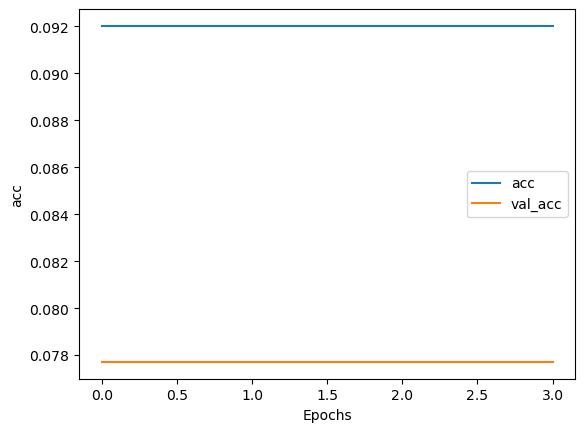

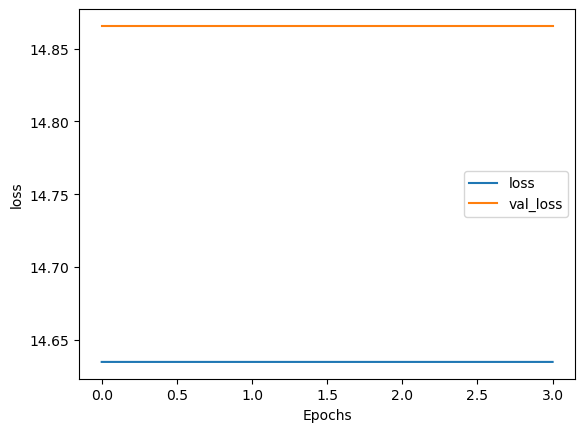

In [63]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [64]:
rf = RandomForestClassifier(n_estimators=550, random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.5746421267893661

### Sklearn RandomForest Model

Model için ön yukarıda yapıldı işlemler yapıldı.

In [65]:
vectorizer = TfidfVectorizer( max_features=7500, min_df=1, max_df=250, stop_words=st.words('english'))
proccessed_features =vectorizer.fit_transform(TestData["Text_Clear"]).toarray()
labels = pd.get_dummies(TestData["sentiment"])
X_train, X_test, y_train, y_test =train_test_split(proccessed_features, labels, test_size=0.3,random_state=42)

In [66]:
text_classifier=RandomForestClassifier(n_estimators=550, random_state=42)
text_classifier.fit(X_train,y_train)

RandomForestClassifier(n_estimators=550, random_state=42)

In [67]:
predictions=text_classifier.predict(X_test)

In [68]:
print(classification_report(y_test,predictions))
print(accuracy_score(y_test,predictions))


              precision    recall  f1-score   support

           0       0.94      0.61      0.74       204
           1       0.75      0.96      0.84       247
           2       0.71      0.39      0.51        38

   micro avg       0.81      0.77      0.79       489
   macro avg       0.80      0.65      0.70       489
weighted avg       0.83      0.77      0.77       489
 samples avg       0.77      0.77      0.77       489

0.7689161554192229


### Lojistik regresyon

 0    801
-1    686
 1    143
Name: sentiment, dtype: int64


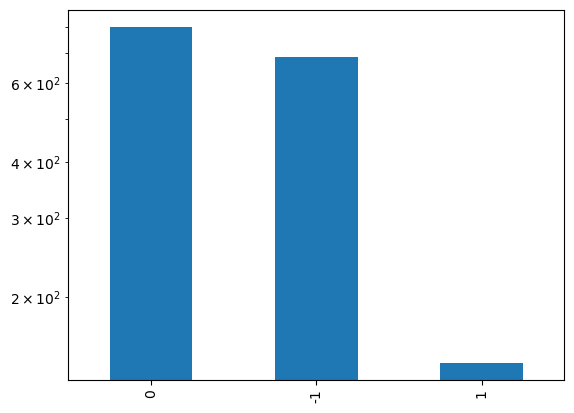

In [69]:
df=pd.read_csv("Test/testData.csv",low_memory=False)
print(df['sentiment'].value_counts())
df['sentiment'].value_counts().plot.bar()
plt.yscale('log')


In [70]:
sentences = df['Text_Clear'].values
y = df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [71]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [72]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.8137254901960784


### Genel Model Sonuçları

In [73]:
#Digits verisetinin çekilmesi
df=pd.read_csv("Test/testData.csv",low_memory=False).dropna()
df=df.fillna(method="bfill")
df = df.reset_index(drop=True)
X = df['Text_Clear'].values
y = df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1000)
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Decision Tree (CART)',DecisionTreeClassifier())) 
models.append(('K-NN', KNeighborsClassifier()))
models.append(('SVM', SVC(kernel="linear")))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('BaggingClassifier', BaggingClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))

# Modelleri test edelim
for name, model in models:
    model = model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    from sklearn import metrics
    print("Model -> %s -> ACC: %%%.2f" % (name,metrics.accuracy_score(y_test, Y_pred)*100))


Model -> Logistic Regression -> ACC: %77.66
Model -> Decision Tree (CART) -> ACC: %71.52
Model -> K-NN -> ACC: %59.84
Model -> SVM -> ACC: %79.51
Model -> AdaBoostClassifier -> ACC: %71.31
Model -> BaggingClassifier -> ACC: %72.95
Model -> RandomForestClassifier -> ACC: %77.66


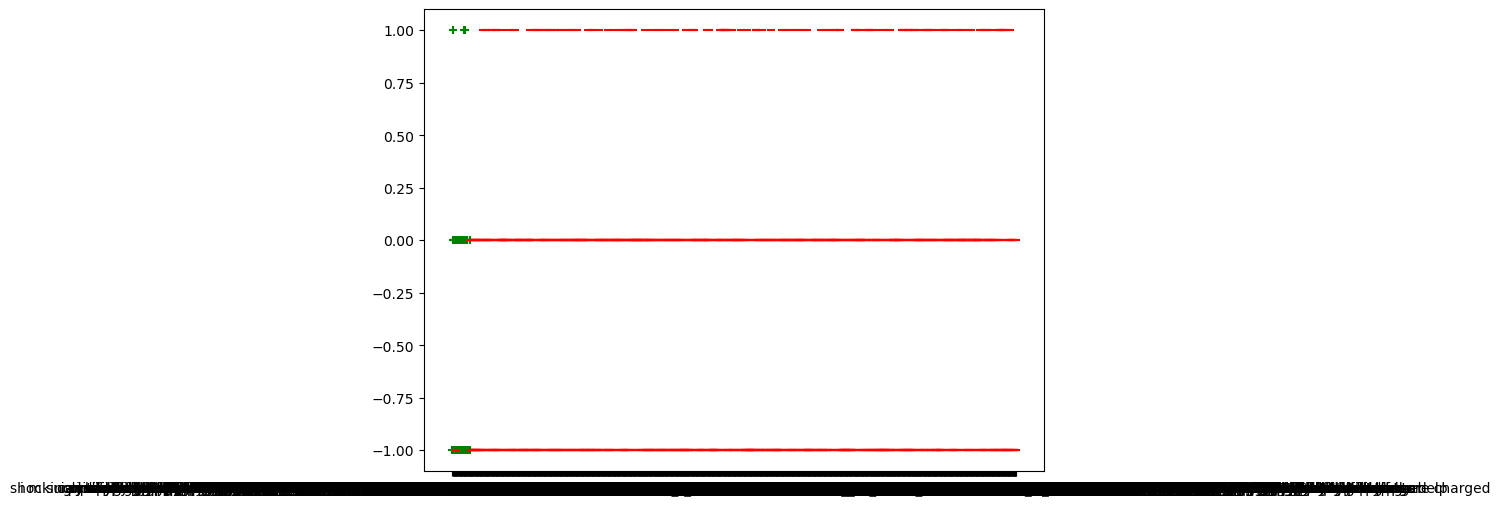

In [74]:
setosa_x = X[:50]
setosa_y = y[:50]

versicolor_x = X[50:]
versicolor_y = y[50:]

plt.figure(figsize=(8,6))
plt.scatter(setosa_x,setosa_y,marker='+',color='green')
plt.scatter(versicolor_x,versicolor_y,marker='_',color='red')
plt.show()

### Derin öğrenme

In [75]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM
from tensorflow.python.keras.optimizers import adam_v2
from tensorflow.python.keras.models import load_model
from sklearn import svm
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cemke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [76]:
df=pd.read_csv("Test/testData.csv",low_memory=False)
sentences = df['Text_Clear'].values
y = df['sentiment'].values

In [77]:
df['Stopword']=df['Stopword'].astype(str)
df['Stopword']

0                                                                    wow yall needa step music snapchat damn time thank
1                                                                                                    happened apple inc
2                                                                            thank u compile pics communicate one place
3                                                                oddly uplifting story apple co founder sold stake aapl
4                                                                     exchange iphone different color lmao changed mind
5                                         apple acted unfairly suppressing digital music competition paul kedrosky aapl
6                                                             let forget press effects stock defend ipod antitrust suit
7                                                                          apple inc deleted songs rival services ipods
8                                       

In [78]:
data = df['Stopword'].values
sentiment = df['sentiment'].values
x_train, x_test, y_train, y_test = train_test_split(data,sentiment,test_size = 0.3, random_state = 42)

In [79]:
tokenizer = tk(num_words = 10000)
tokenizer.fit_on_texts(data)

In [80]:
#her bir yorumu aynı boyuta getirmek gerekiyor RNN böyle çalışıyor.
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [81]:
num_tokens = [len(tokens) for tokens in x_train + x_test]
num_tokens = np.array(num_tokens)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

13

In [82]:
#belirlenen bu sayı verinin yüzde kaçını kapsadığına bakılır.
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9484662576687116

In [83]:
#veriler belirlenen token sayısına göre ayarlanır
x_train_pad = pad_sequences(x_train, maxlen=max_tokens)
x_test_pad = pad_sequences(x_test, maxlen=max_tokens)

In [84]:
def tokenize_pad_sequences(text):
    tokenizer = tk(num_words=13, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=50)
    return X, tokenizer

print('Before Tokenization & Padding \n',data[0])
X, tokenizer = tokenize_pad_sequences(data)
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 wow yall needa step music snapchat damn time thank
After Tokenization & Padding 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [85]:
model = Sequential()
embedding_size = 50
model.add(Embedding(input_dim=10000,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='embedding_layer'))

model.add(LSTM(units=16, return_sequences=True))
model.add(LSTM(units=8, return_sequences=True))
model.add(LSTM(units=4))
model.add(Dense(1, activation='sigmoid'))

In [86]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 13, 50)            500000    
_________________________________________________________________
lstm (LSTM)                  (None, 13, 16)            4288      
_________________________________________________________________
lstm_1 (LSTM)                (None, 13, 8)             800       
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 505,301
Trainable params: 505,301
Non-trainable params: 0
_________________________________________________________________


In [87]:
history = model.fit(x_train_pad, y_train,  batch_size=16,epochs=10, validation_data=(x_test_pad, y_test))

Epoch 1/10
72/72 [==============================] - 8s 54ms/step - loss: 0.2006 - accuracy: 0.4777 - val_loss: -0.3757 - val_accuracy: 0.5051
Epoch 2/10
72/72 [==============================] - 4s 53ms/step - loss: -0.6190 - accuracy: 0.4855 - val_loss: -0.8181 - val_accuracy: 0.5051
Epoch 3/10
72/72 [==============================] - 3s 46ms/step - loss: -0.8693 - accuracy: 0.4855 - val_loss: -0.9654 - val_accuracy: 0.5051
Epoch 4/10
72/72 [==============================] - 3s 46ms/step - loss: -1.0025 - accuracy: 0.4855 - val_loss: -1.0944 - val_accuracy: 0.5051
Epoch 5/10
72/72 [==============================] - 3s 49ms/step - loss: -1.1258 - accuracy: 0.4855 - val_loss: -1.2141 - val_accuracy: 0.5051
Epoch 6/10
72/72 [==============================] - 3s 46ms/step - loss: -1.2433 - accuracy: 0.4855 - val_loss: -1.3244 - val_accuracy: 0.5051
Epoch 7/10
72/72 [==============================] - 3s 42ms/step - loss: -1.3559 - accuracy: 0.4873 - val_loss: -1.4352 - val_accuracy: 0.5051


In [88]:
#GPU desteklemeyen bir sistem ise uzun sürecektir
"""
rf = SVC(kernel='linear')
rf.fit(x_train_pad, y_train)
rf.score(x_test_pad, y_test)
"""

"\nrf = SVC(kernel='linear')\nrf.fit(x_train_pad, y_train)\nrf.score(x_test_pad, y_test)\n"